# Analisis y Guia de E-commerce de Brasil

REQUISITOS: Instalar estas librer√≠as antes de ejecutar el notebook
(Solo si recibes error de importaci√≥n. Puedes instalar desde terminal o una celda as√≠:)
!pip install pandas numpy matplotlib seaborn mlxtend folium wordcloud networkx

In [1]:
pip install pandas numpy matplotlib seaborn mlxtend folium wordcloud networkx

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install mlxtend

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import folium
from folium.plugins import HeatMap
from wordcloud import WordCloud, STOPWORDS
from IPython.display import IFrame, display

Note: you may need to restart the kernel to use updated packages.


# 1. CARGA Y LIMPIEZA DE DATOS

#### Cargamos las bases principales del proyecto Olist.
#### Usamos solo las columnas necesarias para optimizar memoria y velocidad.

In [3]:
orders = pd.read_csv('olist_orders_dataset.csv', 
                     usecols=['order_id', 'customer_id', 'order_purchase_timestamp'],
                     parse_dates=['order_purchase_timestamp'])

customers = pd.read_csv('olist_customers_dataset.csv', 
                        usecols=['customer_id', 'customer_unique_id', 'customer_city', 'customer_state'])

payments = pd.read_csv('olist_order_payments_dataset.csv', 
                       usecols=['order_id', 'payment_value'])

#### Unimos pedidos con clientes y pagos en un solo DataFrame (orders ‚Üí customers ‚Üí payments)

In [4]:
orders = orders.merge(customers, on='customer_id', how='left')
orders_payments = orders.merge(payments, on='order_id', how='left')

# 2. RFM Y SEGMENTACI√ìN DE CLIENTES

#### Creamos un DataFrame para el an√°lisis RFM (Recency, Frequency, Monetary)

In [5]:
rfm_df = orders_payments[['customer_unique_id', 'order_purchase_timestamp', 'order_id', 'payment_value', 
                          'customer_city', 'customer_state']].copy()
rfm_df = rfm_df.rename(columns={'customer_city': 'City', 'customer_state': 'State'})
rfm_df['order_purchase_timestamp'] = pd.to_datetime(rfm_df['order_purchase_timestamp'], errors='coerce')


#### Calculamos la fecha "snapshot" (an√°lisis hasta el d√≠a siguiente al √∫ltimo pedido)

In [6]:
snapshot = rfm_df['order_purchase_timestamp'].max() + pd.Timedelta(days=1)


#### Calculamos RFM por cliente:
#### Recency: d√≠as desde la √∫ltima compra
#### Frequency: cantidad de pedidos realizados
#### Monetary: suma total gastada

In [7]:
rfm = rfm_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum',
    'City': 'last',
    'State': 'last'
}).reset_index()
rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary', 'City', 'State']

#### Escalamos los valores de R, F y M en 4 grupos (cuartiles) para scoring (de 1 a 4)

In [8]:
rfm['R_score'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int) # menor recency es mejor
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['RFM_Score'] = rfm['R_score'].map(str) + rfm['F_score'].map(str) + rfm['M_score'].map(str)

#### Asignamos segmento basado en reglas de negocio

In [9]:
def assign_segment(row):
    if row['R_score']==4 and row['F_score']==4:
        return 'Champions'
    elif row['R_score']>=3 and row['F_score']>=3:
        return 'Loyal Customers'
    elif row['R_score']>=3 and row['F_score']<3:
        return 'Potential Loyalist'
    elif row['R_score']==4:
        return 'Recent Customers'
    elif row['F_score']>=3:
        return 'Frequent Customers'
    elif row['R_score']==2:
        return 'At Risk'
    else:
        return 'Hibernating'
rfm['Segment'] = rfm.apply(assign_segment, axis=1)

Este bloque nos permite identificar los mejores clientes y segmentar para marketing, retenci√≥n o reactivaci√≥n.

# 3. ENRIQUECIMIENTO GEOGR√ÅFICO Y MAPAS DE CALOR

#### Agregamos latitud y longitud promedio a cada ciudad para poder hacer mapas.

In [10]:
geoloc = pd.read_csv('olist_geolocation_dataset.csv',
                     usecols=['geolocation_city', 'geolocation_state', 'geolocation_lat', 'geolocation_lng'])


#### Calculamos coordenadas promedio por ciudad/estado

In [11]:
geo_grouped = (
    geoloc.groupby(['geolocation_city', 'geolocation_state'])
    .agg({'geolocation_lat':'mean', 'geolocation_lng':'mean'})
    .reset_index()
)
geo_grouped['geolocation_city'] = geo_grouped['geolocation_city'].str.lower()
rfm['City_low'] = rfm['City'].str.lower()


#### Merge de rfm con coordenadas para agregar ubicaci√≥n geogr√°fica

In [12]:
rfm_geo = rfm.merge(
    geo_grouped,
    left_on=['City_low', 'State'],
    right_on=['geolocation_city', 'geolocation_state'],
    how='left'
)

#### Visualizaci√≥n: Mapas de calor de clientes Champions y At Risk

In [13]:
for segmento in ['Champions', 'At Risk']:
    rfm_seg = (
        rfm_geo[rfm_geo['Segment'] == segmento]
        .groupby(['City', 'State', 'geolocation_lat', 'geolocation_lng'])
        .size()
        .reset_index(name='Cantidad')
        .dropna(subset=['geolocation_lat', 'geolocation_lng'])
    )
    m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)
    heat_data = [
        [row['geolocation_lat'], row['geolocation_lng'], row['Cantidad']]
        for idx, row in rfm_seg.iterrows()
    ]
    HeatMap(heat_data, radius=13, blur=10, max_zoom=5).add_to(m)
    file_name = f"heatmap_ciudades_{segmento.lower()}.html"
    m.save(file_name)
    display(IFrame(file_name, width=700, height=500))

As√≠ podemos visualizar geogr√°ficamente d√≥nde est√°n los mejores clientes y los que requieren intervenci√≥n.

# 4. MARKET BASKET ANALYSIS (AN√ÅLISIS DE PRODUCTOS FRECUENTES)

#### Cargamos √≠tems de cada orden y sus categor√≠as, para identificar combinaciones frecuentes.

In [14]:
order_items = pd.read_csv('olist_order_items_dataset.csv', usecols=['order_id', 'product_id'])
products = pd.read_csv('olist_products_dataset.csv', usecols=['product_id', 'product_category_name'])
categories = pd.read_csv('product_category_name_translation.csv')
products = products.merge(categories, on='product_category_name', how='left')
order_items = order_items.merge(products[['product_id', 'product_category_name_english']], on='product_id', how='left')

#### Creamos una columna con el nombre de categor√≠a (o id si falta)

In [15]:
order_items['basket_item'] = order_items['product_category_name_english'].fillna(order_items['product_id'])


#### Creamos la matriz orden-producto (uno-hot) para usar en Apriori

In [16]:
basket = order_items.groupby(['order_id', 'basket_item']).size().unstack(fill_value=0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)


C:\Users\Facun\AppData\Local\Temp\ipykernel_8628\1520332979.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


#### Ejecutamos Apriori para encontrar conjuntos frecuentes y reglas de asociaci√≥n

In [17]:
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.1)
top_rules = rules.sort_values('confidence', ascending=False).head(10)

c:\Users\Facun\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Te ayuda a identificar productos que se compran juntos, ideal para combos y promociones cruzadas.

# 5. VISUALIZACIONES CLAVE DE SEGMENTOS, CLV Y FRECUENCIA

#### Gr√°fico: distribuci√≥n de clientes por segmento RFM

C:\Users\Facun\AppData\Local\Temp\ipykernel_8628\1336389807.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Segment', data=rfm_geo, order=rfm_geo['Segment'].value_counts().index, palette='tab10')


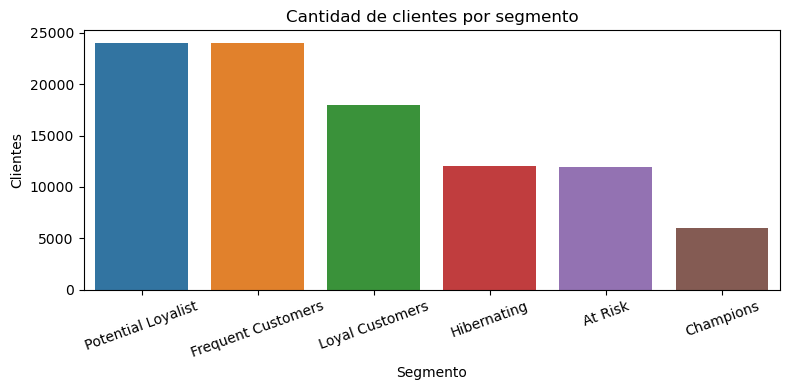

In [18]:
plt.figure(figsize=(8,4))
sns.countplot(x='Segment', data=rfm_geo, order=rfm_geo['Segment'].value_counts().index, palette='tab10')
plt.title('Cantidad de clientes por segmento')
plt.xlabel('Segmento')
plt.ylabel('Clientes')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

#### Gr√°fico: Ticket promedio por segmento


C:\Users\Facun\AppData\Local\Temp\ipykernel_8628\770031986.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Segment', y='Monetary', data=rfm_geo, order=rfm_geo['Segment'].value_counts().index, palette='tab10')


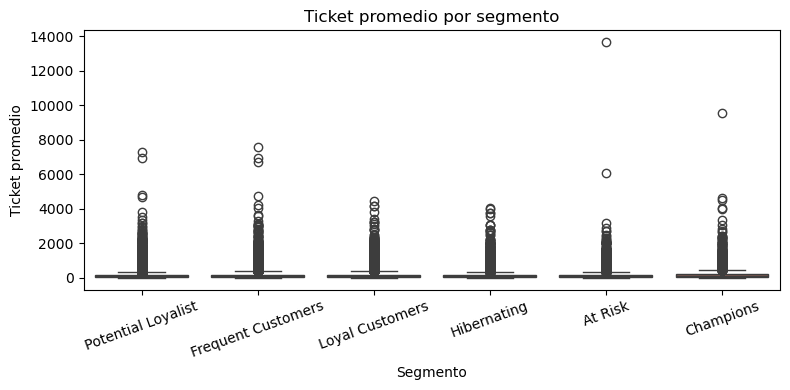

In [19]:
plt.figure(figsize=(8,4))
sns.boxplot(x='Segment', y='Monetary', data=rfm_geo, order=rfm_geo['Segment'].value_counts().index, palette='tab10')
plt.title('Ticket promedio por segmento')
plt.xlabel('Segmento')
plt.ylabel('Ticket promedio')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

Estas visualizaciones muestran el tama√±o y poder de compra de cada segmento para decisiones comerciales.

# 6. FRECUENCIA DE RECOMPRA Y VALOR DE VIDA DEL CLIENTE (CLV)

#### Calculamos cu√°ntas compras hace cada cliente


In [20]:
compra_freq = orders_payments.groupby('customer_unique_id')['order_id'].nunique().reset_index()
compra_freq.columns = ['customer_unique_id', 'num_compras']
compra_freq = compra_freq.merge(
    rfm.rename(columns={'customer_id':'customer_unique_id'}),
    on='customer_unique_id', how='left'
)

#### Histograma de frecuencia de recompra

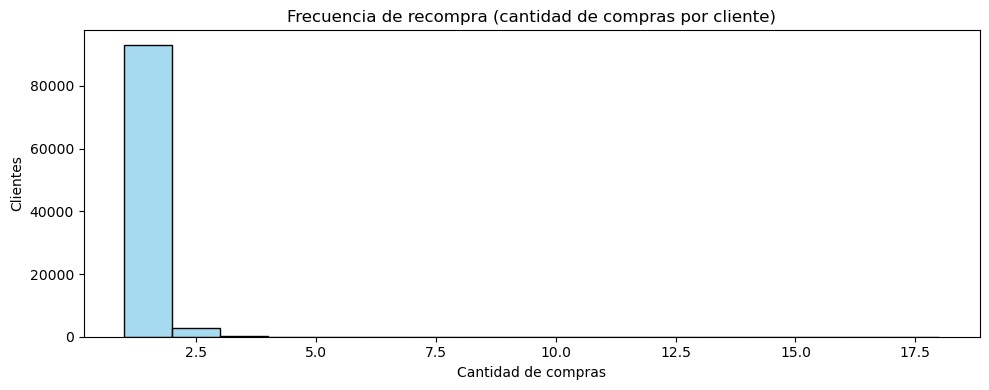

In [21]:
plt.figure(figsize=(10,4))
sns.histplot(compra_freq['num_compras'], bins=range(1, compra_freq['num_compras'].max()+2), kde=False, color='skyblue')
plt.title('Frecuencia de recompra (cantidad de compras por cliente)')
plt.xlabel('Cantidad de compras')
plt.ylabel('Clientes')
plt.tight_layout()
plt.show()

#### Calculamos CLV simple (suma total de pagos por cliente)

In [22]:
clv = orders_payments.groupby('customer_unique_id')['payment_value'].sum().reset_index()
clv.columns = ['customer_unique_id', 'clv']
clv = clv.merge(compra_freq[['customer_unique_id', 'num_compras', 'Segment']], on='customer_unique_id', how='left')

#### Histograma del CLV

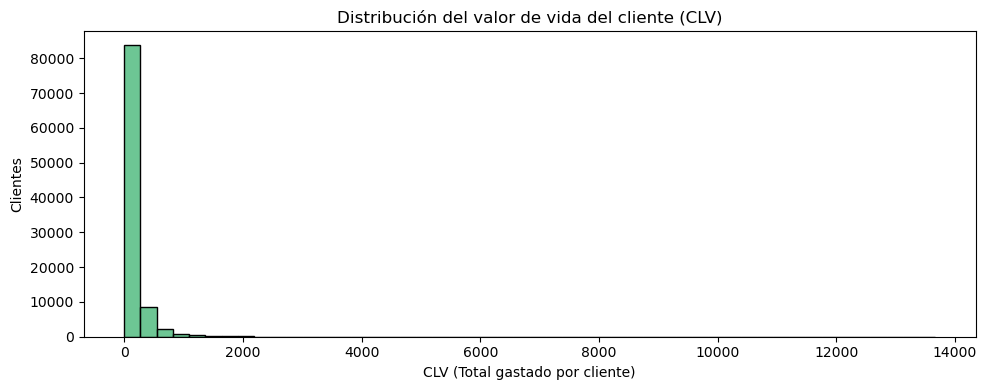

In [23]:
plt.figure(figsize=(10,4))
sns.histplot(clv['clv'], bins=50, color='mediumseagreen')
plt.title('Distribuci√≥n del valor de vida del cliente (CLV)')
plt.xlabel('CLV (Total gastado por cliente)')
plt.ylabel('Clientes')
plt.tight_layout()
plt.show()

Con esto podemos identificar a los clientes m√°s valiosos y su potencial para aumentar ventas y fidelizaci√≥n.


# 7. MIGRACI√ìN DE CLIENTES VIP ENTRE SEGMENTOS (Champions ‚Üí At Risk)

#### Analizamos c√≥mo evolucionan los segmentos mes a mes

In [24]:
rfm_df['order_month'] = rfm_df['order_purchase_timestamp'].dt.to_period('M')
rfm_time = rfm_df.groupby(['customer_unique_id', 'order_month']).agg({
    'order_purchase_timestamp': lambda x: (snapshot - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
}).reset_index()
rfm_time.columns = ['customer_unique_id', 'order_month', 'Recency', 'Frequency', 'Monetary']

#### Recalcula scores y segmento cada mes

In [25]:
rfm_time['R_score'] = pd.qcut(rfm_time['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm_time['F_score'] = pd.qcut(rfm_time['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm_time['M_score'] = pd.qcut(rfm_time['Monetary'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm_time['RFM_Score'] = rfm_time['R_score'].map(str) + rfm_time['F_score'].map(str) + rfm_time['M_score'].map(str)
rfm_time['Segment'] = rfm_time.apply(assign_segment, axis=1)

#### Analizamos migraciones entre segmentos (Champions ‚Üí At Risk)


In [26]:
rfm_time = rfm_time.sort_values(['customer_unique_id', 'order_month'])
rfm_time['next_segment'] = rfm_time.groupby('customer_unique_id')['Segment'].shift(-1)
rfm_time['migration'] = rfm_time['Segment'] + ' ‚Üí ' + rfm_time['next_segment'].fillna('None')
champ_to_risk = rfm_time[rfm_time['migration'] == 'Champions ‚Üí At Risk']

In [27]:
print(f"Clientes que pasaron de 'Champions' a 'At Risk': {champ_to_risk['customer_unique_id'].nunique()}")

Clientes que pasaron de 'Champions' a 'At Risk': 0


Los mejores clientes (‚ÄúChampions‚Äù) se mantuvieron activos y comprometidos con la marca durante el per√≠odo analizado.
No se detectaron se√±ales de alarma sobre la posible p√©rdida de tus principales clientes.
Las acciones de marketing, experiencia, o fidelizaci√≥n parecen estar funcionando bien para retener a los clientes m√°s valiosos.
Esta estabilidad puede ser una fortaleza frente a la competencia y una oportunidad para seguir construyendo relaciones de largo plazo.



#### Visualizaci√≥n de todas las migraciones desde Champions


C:\Users\Facun\AppData\Local\Temp\ipykernel_8628\3805480386.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=migraciones_champions.index, y=migraciones_champions.values, palette='Reds')


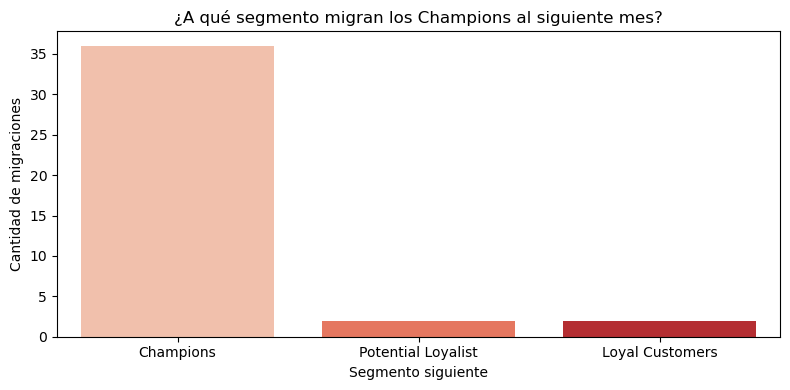

In [28]:
migraciones_champions = rfm_time[rfm_time['Segment'] == 'Champions']['next_segment'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=migraciones_champions.index, y=migraciones_champions.values, palette='Reds')
plt.title('¬øA qu√© segmento migran los Champions al siguiente mes?')
plt.xlabel('Segmento siguiente')
plt.ylabel('Cantidad de migraciones')
plt.tight_layout()
plt.show()

Este an√°lisis nos permite monitorear la salud de la base de clientes y detectar alertas tempranas para campa√±as de retenci√≥n.


# 8. AN√ÅLISIS DE REVIEWS: NUBE DE PALABRAS

#### Cargamos la base de reviews de Olist

In [36]:
reviews = pd.read_csv('olist_order_reviews_dataset.csv')

#### Concatenamos todos los comentarios en un solo texto

In [37]:
texto = " ".join(str(r) for r in reviews['review_comment_message'].dropna())

#### Generamos la nube de palabras

In [38]:
wordcloud = WordCloud(
    stopwords=STOPWORDS, 
    background_color='white',
    max_words=100,
    width=800, 
    height=400
).generate(texto)

#### Mostramos la nube de palabras

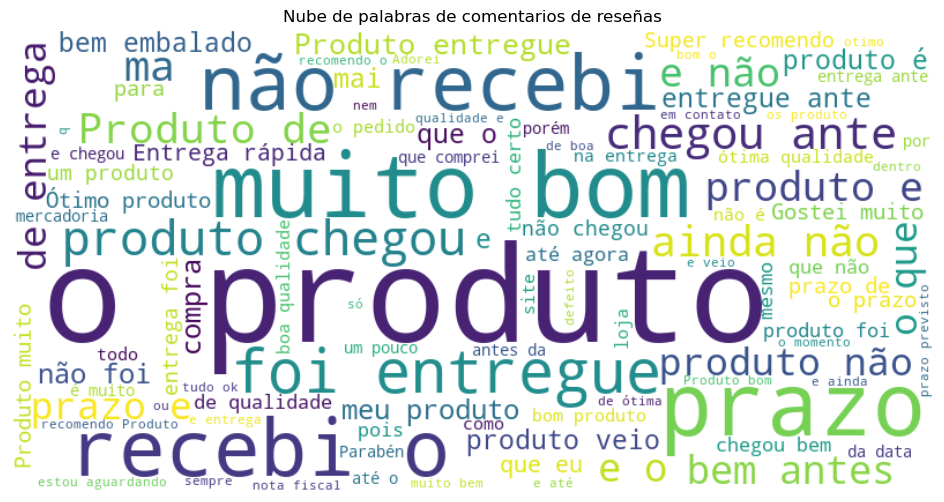

In [39]:
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de comentarios de rese√±as')
plt.show()


Este an√°lisis permite visualizar de forma r√°pida las palabras y temas m√°s recurrentes en los comentarios de los clientes.
Es √∫til para identificar oportunidades de mejora en la experiencia, potenciales problemas frecuentes y fortalezas percibidas por los usuarios.

# 9. CONCLUSIONES DE NEGOCIO

### - Los clientes ‚ÄúChampions‚Äù y ‚ÄúLoyal Customers‚Äù son el principal motor de ventas y deben ser retenidos con campa√±as especiales.
### - El an√°lisis de Market Basket nos ayuda a identificar productos para promociones cruzadas o bundles.
### - Los mapas permiten geolocalizar oportunidades y amenazas (zonas con muchos "At Risk").
### - Analizar la migraci√≥n de segmentos ayuda a anticipar p√©rdida de clientes y tomar decisiones proactivas.
### - Los KPIs de CLV y frecuencia deben usarse para definir descuentos, retenci√≥n y nuevos lanzamientos.

# 10. RESUMEN EJECUTIVO Y RECOMENDACIONES DE NEGOCIO

In [29]:
print("======= RESUMEN EJECUTIVO OLIST =======\n")

======= RESUMEN EJECUTIVO OLIST =======



## 1. Champions y Loyal Customers

In [30]:
num_champions = rfm[rfm['Segment'] == 'Champions'].shape[0]
num_loyal = rfm[rfm['Segment'] == 'Loyal Customers'].shape[0]
print(f"‚úîÔ∏è Clientes 'Champions': {num_champions}")
print(f"‚úîÔ∏è Clientes 'Loyal Customers': {num_loyal}")
print("SUGERENCIA: Focalizar campa√±as de retenci√≥n, membres√≠as y beneficios exclusivos en estos segmentos.")


‚úîÔ∏è Clientes 'Champions': 6049
‚úîÔ∏è Clientes 'Loyal Customers': 17970
SUGERENCIA: Focalizar campa√±as de retenci√≥n, membres√≠as y beneficios exclusivos en estos segmentos.


## 2. At Risk y Hibernating

In [31]:
num_at_risk = rfm[rfm['Segment'] == 'At Risk'].shape[0]
num_hibernating = rfm[rfm['Segment'] == 'Hibernating'].shape[0]
print(f"‚ö†Ô∏è Clientes 'At Risk': {num_at_risk}")
print(f"‚ö†Ô∏è Clientes 'Hibernating': {num_hibernating}")
print("SUGERENCIA: Enviar campa√±as de recuperaci√≥n, encuestas breves y ofertas de reactivaci√≥n.")

‚ö†Ô∏è Clientes 'At Risk': 11929
‚ö†Ô∏è Clientes 'Hibernating': 12063
SUGERENCIA: Enviar campa√±as de recuperaci√≥n, encuestas breves y ofertas de reactivaci√≥n.


## 3. Mapas de calor y oportunidades geogr√°ficas

In [32]:
if rfm_geo['geolocation_city'].notnull().any():
    top_city = rfm_geo[rfm_geo['Segment'] == 'Champions']['City'].value_counts().idxmax()
    print(f"üèôÔ∏è Ciudad con m√°s Champions: {top_city}")
    print("SUGERENCIA: Potenciar acciones comerciales, alianzas y log√≠stica en esta ciudad y las principales del heatmap.")
else:
    print("No se pudo determinar la ciudad top por falta de datos geogr√°ficos.")

üèôÔ∏è Ciudad con m√°s Champions: sao paulo
SUGERENCIA: Potenciar acciones comerciales, alianzas y log√≠stica en esta ciudad y las principales del heatmap.


## 4. Productos y Market Basket

In [33]:
if not top_rules.empty:
    productos_lift = ', '.join([', '.join(x) for x in top_rules['antecedents'].iloc[:3]])
    print(f"üõí Productos frecuentemente comprados juntos: {productos_lift}")
    print("SUGERENCIA: Armar bundles y ofertas en estos productos para aumentar el ticket promedio.")
else:
    print("No se detectaron reglas significativas de asociaci√≥n de productos.")

No se detectaron reglas significativas de asociaci√≥n de productos.


## 5. Migraci√≥n de clientes VIP

In [34]:
n_migran = champ_to_risk['customer_unique_id'].nunique()
print(f"üîÑ Clientes 'Champions' que migraron a 'At Risk' el mes siguiente: {n_migran}")
if n_migran > 0:
    print("SUGERENCIA: Contactar personalmente a estos clientes, investigar motivos de baja y ofrecer beneficios personalizados.")
else:
    print("¬°No hay Champions migrando a At Risk! Mantener la estrategia actual de fidelizaci√≥n.")

üîÑ Clientes 'Champions' que migraron a 'At Risk' el mes siguiente: 0
¬°No hay Champions migrando a At Risk! Mantener la estrategia actual de fidelizaci√≥n.


## 6. CLV y recompra

In [35]:
mean_clv = clv['clv'].mean()
mean_freq = compra_freq['num_compras'].mean()
print(f"üí∞ CLV (valor de vida promedio): ${mean_clv:.2f}")
print(f"üîÅ Frecuencia de recompra promedio: {mean_freq:.2f} compras por cliente")
print("SUGERENCIA: Incentivar la recompra con programas de puntos, emails de reactivaci√≥n y descuentos post-compra.\n")

print("======= FIN DEL RESUMEN EJECUTIVO =======")

üí∞ CLV (valor de vida promedio): $166.59
üîÅ Frecuencia de recompra promedio: 1.03 compras por cliente
SUGERENCIA: Incentivar la recompra con programas de puntos, emails de reactivaci√≥n y descuentos post-compra.

======= FIN DEL RESUMEN EJECUTIVO =======
